# Assigment 3: Data Mining In Action

## Initial Data Exploration and PreProcessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


#TrainAndTestSet
TrainTest_Set = pd.read_csv('Assignment3-WeatherData.csv')

#Real Datset to be predicted
RealSample = pd.read_csv('Assignment3-UnknownData.csv')

# Initialize the label encoder
label_encoder = LabelEncoder()

# Apply label encoding to the 'RainToday' column
TrainTest_Set['RainToday'] = label_encoder.fit_transform(TrainTest_Set['RainToday'])

#Binarisation For Locations
TrainTest_Set = pd.get_dummies(TrainTest_Set)

In [2]:
imputer = KNNImputer(n_neighbors=5)
TrainTest_Set_Imputed = imputer.fit_transform(TrainTest_Set)


In [5]:
RealSample_Imputed = RealSample.drop(RealSample.columns[0], axis=1)
RealSample_Imputed['RainToday'] = label_encoder.transform(RealSample['RainToday'])
RealSample_Imputed = pd.get_dummies(RealSample_Imputed)
RealSample_Imputed = imputer.fit_transform(RealSample_Imputed)

array([[14.6, 29.7,  0.2, ...,  1. ,  0. ,  0. ],
       [19.7, 27.2,  0. , ...,  0. ,  0. ,  1. ],
       [21.7, 36.9,  0. , ...,  0. ,  0. ,  0. ],
       ...,
       [17.5, 39.7,  0. , ...,  0. ,  0. ,  0. ],
       [23.1, 39.9,  0. , ...,  0. ,  1. ,  0. ],
       [11.5, 28.6,  0. , ...,  0. ,  0. ,  0. ]])

## Classifiers

### Decision Tree Classifier

In [46]:
#Import the packages required for building a decision tree classifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

TrainTest_Set_Imputed = pd.DataFrame(TrainTest_Set_Imputed, columns=TrainTest_Set.columns)

X = TrainTest_Set_Imputed.drop('RainTomorrow', axis=1)
y = TrainTest_Set_Imputed['RainTomorrow']
test_size = 0.2
random_seed = 42

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size, random_state=random_seed)

model = DecisionTreeClassifier()
model.fit(X_train, y_train)



DecisionTreeClassifier()

#### Model Evaluation

In [47]:
# Import required packages for evaluating a classification model using the test dataset
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc


In [48]:
#predict the class labels for the test set
y_pred = model.predict(X_test)

Accuracy : 0.7794921875
              precision    recall  f1-score   support

         0.0       0.86      0.86      0.86      7916
         1.0       0.51      0.52      0.52      2324

    accuracy                           0.78     10240
   macro avg       0.69      0.69      0.69     10240
weighted avg       0.78      0.78      0.78     10240



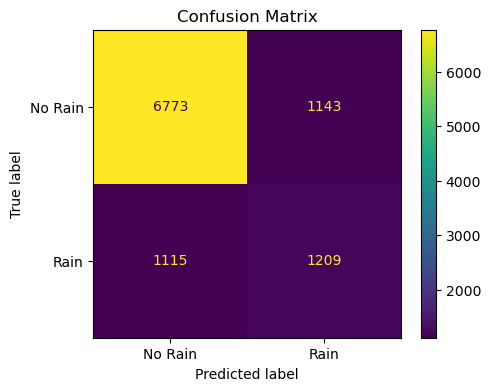

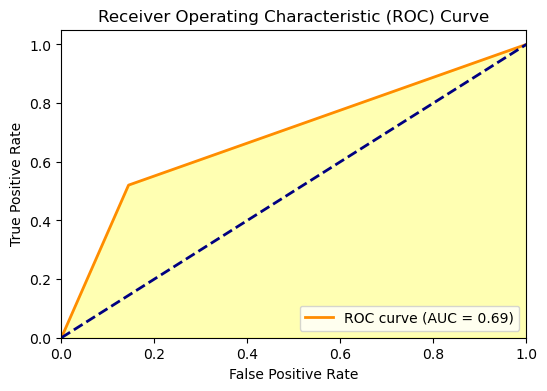

In [49]:
#configure some performance evaluation metrics
def evaluate(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    #Output Results
    print(f'Accuracy : {accuracy}')
    print(class_report)


    cm = confusion_matrix(y_test, y_pred)

    # Create a confusion matrix display
    fig, ax = plt.subplots(figsize=(5, 4), dpi=100)
    cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Rain", "Rain"])
    cmp.plot(ax=ax)

    # Set the title
    plt.title('Confusion Matrix')
    return plt.show()

def plot_roc_curve(model, y_test):
    #Define the predicted probabilities
    y_pred_prob = model.predict_proba(X_test)[:,1]
    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    
    # Calculate the AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.figure(figsize=(6, 4), dpi=100)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.fill_between(fpr, tpr, color='yellow', alpha=0.3)

    # Plot a diagonal line (chance curve)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    # Labels and title
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()




evaluate(y_test, y_pred)
plot_roc_curve(model, y_test)


In [51]:
def create_submission(model, classifier_name):
    Real_Pred = model.predict(RealSample_Imputed)
    Real_Pred = pd.DataFrame(Real_Pred)
    Row_ID = RealSample['row ID']
    Real_Pred.columns = ['Predict_RainTomorrow']
    Real_Pred = pd.concat([Row_ID, Real_Pred], axis=1)
    
    # Create the CSV filename using the classifier_name
    filename = f"{classifier_name}_submission.csv"
    
    # Save the DataFrame to a CSV file with the created filename
    Real_Pred.to_csv(filename, index=False)
    
    return Real_Pred



In [52]:
create_submission(model, 'DecisionTree')


c:\Users\61422\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


,row ID,Predict_RainTomorrow
0,Row0,0.0
1,Row1,0.0
2,Row2,0.0
3,Row3,0.0
4,Row4,0.0
...,...,...
9960,Row9960,0.0
9961,Row9961,0.0
9962,Row9962,0.0
9963,Row9963,0.0


### K Nearest Neighbour

In [54]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)


KNeighborsClassifier()

In [55]:
y_pred= knn_model.predict(X_test)

Accuracy : 0.83349609375
              precision    recall  f1-score   support

         0.0       0.86      0.93      0.90      7916
         1.0       0.68      0.50      0.57      2324

    accuracy                           0.83     10240
   macro avg       0.77      0.71      0.74     10240
weighted avg       0.82      0.83      0.82     10240



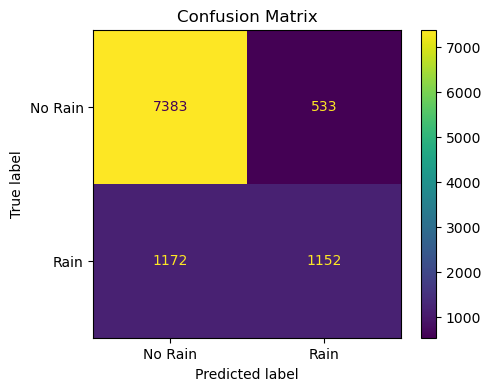

In [56]:
evaluate(y_test, y_pred)

In [57]:
create_submission(knn_model, 'KNN')

c:\Users\61422\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


,row ID,Predict_RainTomorrow
0,Row0,0.0
1,Row1,0.0
2,Row2,0.0
3,Row3,0.0
4,Row4,0.0
...,...,...
9960,Row9960,0.0
9961,Row9961,0.0
9962,Row9962,0.0
9963,Row9963,0.0


### Random Forest

In [58]:
from sklearn.ensemble import RandomForestClassifier

forrest_model = RandomForestClassifier(n_estimators=100, random_state=42)

forrest_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [28]:
y_pred= forrest_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

Accuracy : 0.84638671875
              precision    recall  f1-score   support

           0       0.86      0.95      0.91      7916
           1       0.75      0.49      0.59      2324

    accuracy                           0.85     10240
   macro avg       0.81      0.72      0.75     10240
weighted avg       0.84      0.85      0.83     10240



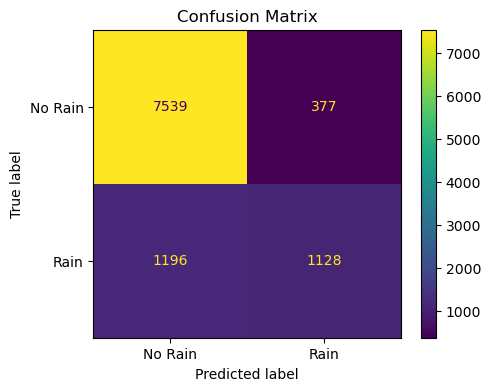

In [29]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

#Output Results
print(f'Accuracy : {accuracy}')
print(class_report)


cm = confusion_matrix(y_test, y_pred)

# Create a confusion matrix display
fig, ax = plt.subplots(figsize=(5, 4), dpi=100)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Rain", "Rain"])
cmp.plot(ax=ax)

# Set the title
plt.title('Confusion Matrix')
plt.show()


In [30]:
create_submission(forrest_model, 'RandomForest')

c:\Users\61422\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


,row ID,Predict_RainTomorrow
0,Row0,0
1,Row1,0
2,Row2,0
3,Row3,0
4,Row4,0
...,...,...
9960,Row9960,0
9961,Row9961,0
9962,Row9962,0
9963,Row9963,0


### Support Vector Machine

Accuracy : 0.84462890625
              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90      7916
         1.0       0.72      0.51      0.60      2324

    accuracy                           0.84     10240
   macro avg       0.80      0.73      0.75     10240
weighted avg       0.84      0.84      0.83     10240



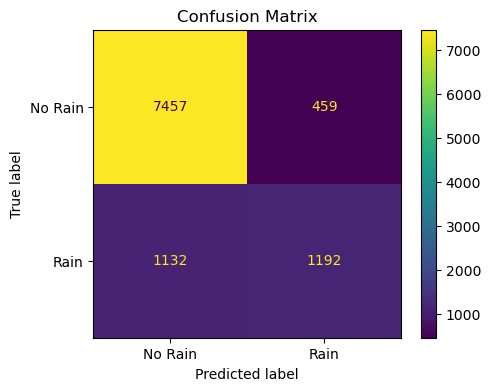

In [59]:
from sklearn import svm

model = svm.SVC(kernel='linear', C=1, random_state=42)
model.fit(X_train, y_train)
y_pred= model.predict(X_test)
evaluate(y_test, y_pred)


In [60]:
create_submission(model, 'SVM')

c:\Users\61422\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


,row ID,Predict_RainTomorrow
0,Row0,0.0
1,Row1,0.0
2,Row2,0.0
3,Row3,0.0
4,Row4,0.0
...,...,...
9960,Row9960,0.0
9961,Row9961,0.0
9962,Row9962,0.0
9963,Row9963,0.0


### Neural Network

Accuracy : 0.81591796875
              precision    recall  f1-score   support

         0.0       0.90      0.86      0.88      7916
         1.0       0.58      0.67      0.62      2324

    accuracy                           0.82     10240
   macro avg       0.74      0.77      0.75     10240
weighted avg       0.83      0.82      0.82     10240



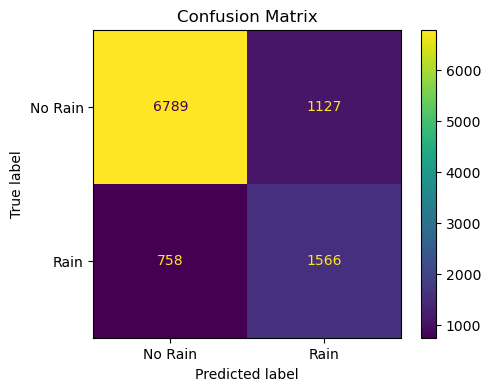

In [61]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=500, random_state=42)
model.fit(X_train, y_train)
y_pred= model.predict(X_test)
evaluate(y_test, y_pred)